# Moselle paper: Distributed model

In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [41]:
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [38]:
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [40]:
path_estreams

'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [42]:
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,[CH000197],1,16,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,[CH000221],1,1,[AT000002]
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,[CH000215],1,2,"[AT000002, AT000003, CH000221]"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,[CH000227],1,1,[AT000004]
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,[CH000214],1,3,"[AT000005, CH000214]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,[UAGR0017]
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,[UAGR0018]
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,[UAGR0019]


In [43]:
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


In [29]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [113]:
geology_regional = pd.read_csv("../data/estreams_geology_garonne_regional_attributes.csv", encoding='utf-8')
geology_regional.columns

Index(['basin_id', 'lit_fra_Alluvium', 'lit_fra_Carbonate rocks',
       'lit_fra_Granitoids', 'lit_fra_Impermeable', 'lit_fra_Inland water',
       'lit_fra_Limestones', 'lit_fra_Limestones, sandstones and gravels',
       'lit_fra_Limestones, sandstones and marls', 'lit_fra_Magmatic rocks',
       'lit_fra_Massif', 'lit_fra_Molasses and clays',
       'lit_fra_Plutonic rocks', 'lit_fra_Sand, gravel and pebbles',
       'lit_fra_Sands and clays', 'lit_fra_Schists, gneisses, granites',
       'lit_fra_Sedimentary rocks', 'lit_fra_Sediments mesosoics',
       'lit_fra_Shales', 'lit_dom', 'tot_area'],
      dtype='object')

In [128]:
geology_regional = pd.read_csv("../data/estreams_geology_garonne_regional_attributes.csv", encoding='utf-8')

geology_regional.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 
             'lit_fra_Sand, gravel and pebbles'    
        ],
    
    "medium": ['lit_fra_Carbonate rocks', 
               'lit_fra_Limestones', 
               'lit_fra_Limestones, sandstones and gravels', 
               'lit_fra_Limestones, sandstones and marls', 
               'lit_fra_Molasses and clays',  
               'lit_fra_Sands and clays',
               'lit_fra_Schists, gneisses, granites', 
                'lit_fra_Sedimentary rocks',
               'lit_fra_Sediments mesosoics'
             ],
    
    "low": ['lit_fra_Impermeable', 
            'lit_fra_Inland water', 
            'lit_fra_Magmatic rocks', 
            'lit_fra_Massif', 
            'lit_fra_Plutonic rocks',
            'lit_fra_Shales',
                           'lit_fra_Granitoids',

                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional[f'area_perm_{permeability_class}'] = geology_regional[columns].sum(axis=1)



# Drop unnecessary columns
geology_regional = geology_regional[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]


# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]
estreams_attributes

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,22.0,NaN,NaN,NaN,25.952,67.928,5.886,9.347,81.658,8.997
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,18.0,NaN,NaN,NaN,0.070,99.816,0.115,8.263,68.808,22.929
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10.0,NaN,NaN,NaN,0.000,98.532,0.000,0.298,98.687,1.015
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,40.0,NaN,NaN,NaN,0.033,99.821,0.054,9.716,78.201,12.083
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,8.0,NaN,NaN,NaN,13.430,86.571,0.000,0.000,100.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,4.0,NaN,NaN,NaN,5.258,82.319,12.422,11.538,29.876,58.587
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3.0,NaN,NaN,NaN,57.276,42.724,0.000,15.677,24.488,59.835
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,1.0,NaN,NaN,NaN,14.175,85.825,0.000,1.644,72.670,25.686


In [129]:
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

In [130]:
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]

In [131]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100

In [117]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [36]:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_cont2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_cont2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_cont2"] = v3 * 100

In [132]:
# First we define the outlet of the Moselle to be used
outlets = ["FR001604"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["FR001604"]

100%|██████████| 1/1 [00:00<00:00, 1012.38it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
ES000333,9019,BOSSOST,ES,ES_CEDEX,NaN,0.691225,42.782327,0.691225,42.782327,700,...,6.0,0.0,6.0,94.0,0.000,96.170,3.161,0.000,5.999,94.000
ES000453,9143,ARTIES,ES,ES_CEDEX,NaN,0.879104,42.701971,0.879104,42.701971,1180,...,4.0,0.0,2.0,98.0,0.000,90.941,8.611,0.000,2.020,97.980
FR004086,O005002001,La Garonne Ã Chaum et Ã Fronsac,FR,FR_EAUFRANCE,La Garonne à Chaum et à Fronsac,0.647726,42.938900,0.647726,42.938900,465,...,8.0,0.0,4.0,96.0,12.183,83.086,4.442,0.107,4.369,95.523
FR004089,O014402001,La Neste ÃƒÂ Arreau [Aure],FR,FR_EAUFRANCE,La Neste à Arreau [Aure],0.356667,42.904167,0.357420,42.905599,NaN,...,3.0,0.0,0.0,100.0,28.334,60.247,11.413,0.000,2.623,97.377
FR004091,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,0.0,0.0,49.0,51.0,3.918,87.254,8.827,0.000,49.849,50.151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR001593,O222251001,O2222510,FR,FR_EAUFRANCE,L'Hers à Toulouse [Pont de Périole],1.480100,43.627770,1.480100,43.627770,140,...,5.0,1.0,99.0,0.0,16.528,83.472,0.000,18.997,81.003,0.000
FR001595,O232401001,O2324010,FR,FR_EAUFRANCE,Le Girou à Bourg-Saint-Bernard,1.690766,43.623780,1.690766,43.623780,157,...,2.0,0.0,100.0,0.0,5.916,94.084,0.000,0.000,100.000,0.000
FR001596,O232401002,O2324020,FR,FR_EAUFRANCE,Le Girou à Bourg-Saint-Bernard,1.719739,43.615009,1.719739,43.615009,157,...,2.0,0.0,100.0,0.0,4.946,95.054,0.000,0.000,100.000,0.000


In [133]:
estreams_attributes_clipped = estreams_attributes_dfs["FR001604"]
catchments_ids = estreams_attributes_clipped.index.tolist()

In [134]:
estreams_attributes_clipped.corr(method="spearman")["baseflow_index"][-10:]

C:\Users\nascimth\AppData\Local\Temp\ipykernel_28752\1375779775.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped.corr(method="spearman")["baseflow_index"][-10:]


stations_num_p_mean    0.493501
perm_high_regi         0.144169
perm_medium_regi      -0.777847
perm_low_regi          0.760508
perm_high_glob2        0.196783
perm_medium_glob2     -0.395986
perm_low_glob2         0.801799
perm_high_cont2       -0.063574
perm_medium_cont2     -0.841993
perm_low_cont2         0.787246
Name: baseflow_index, dtype: float64

In [135]:
estreams_attributes_clipped[['perm_high_regi', 'perm_medium_regi',
       'perm_low_regi', 'perm_high_cont2', 'perm_medium_cont2',
       'perm_low_cont2']]

,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,
ES000333,0.0,6.0,94.0,0.000,5.999,94.000
ES000453,0.0,2.0,98.0,0.000,2.020,97.980
FR004086,0.0,4.0,96.0,0.107,4.369,95.523
FR004089,0.0,0.0,100.0,0.000,2.623,97.377
FR004091,0.0,49.0,51.0,0.000,49.849,50.151
...,...,...,...,...,...,...
FR001593,1.0,99.0,0.0,18.997,81.003,0.000
FR001595,0.0,100.0,0.0,0.000,100.000,0.000
FR001596,0.0,100.0,0.0,0.000,100.000,0.000


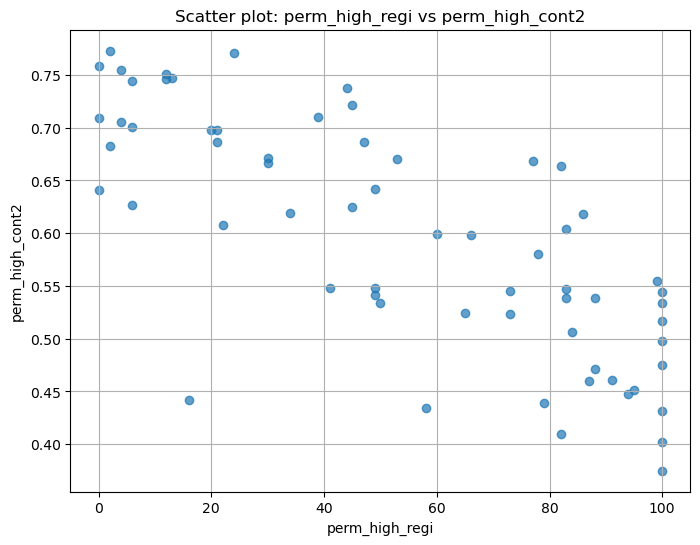

In [154]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_regi']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


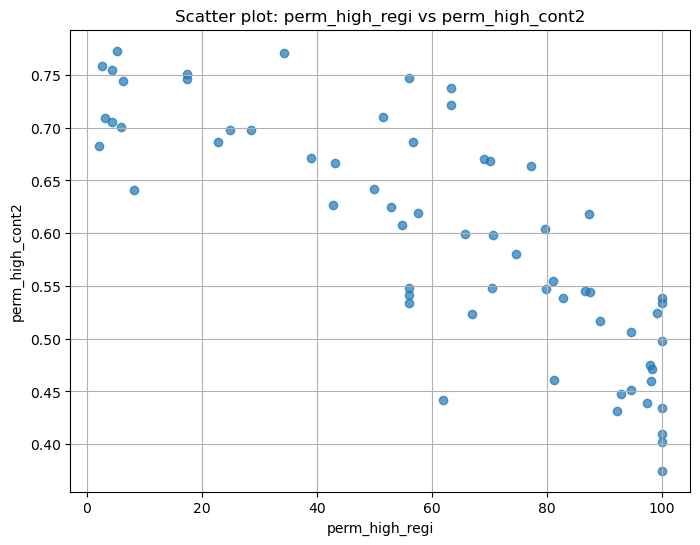

In [153]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_cont2']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


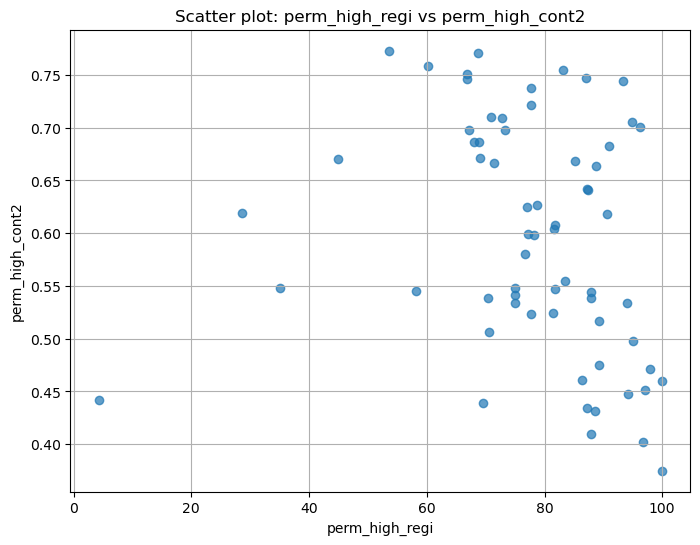

In [155]:
import matplotlib.pyplot as plt

# Choose two columns to plot
x = estreams_attributes_clipped['perm_medium_glob2']
y = estreams_attributes_clipped['baseflow_index']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('perm_high_regi')
plt.ylabel('perm_high_cont2')
plt.title('Scatter plot: perm_high_regi vs perm_high_cont2')
plt.grid(True)
plt.show()


In [136]:
#path_estreams = fr'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Data/'


# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}
perm_areasglobal = {}
perm_areascontinental = {}
prec_mean = {}
nan_counts_dict = {}
# Function to compute S_dem per water year
def compute_S_dem(group):
    group = group.copy()
    group.iloc[0, group.columns.get_loc('S_dem(t-1)')] = 0
    group.iloc[0, group.columns.get_loc('S_dem(t)')] = max(
        0, group.iloc[0]['S_dem(t-1)'] + (group.iloc[0]['pet_mean'] - group.iloc[0]['p_mean'])
    )

    for i in range(1, len(group)):
        group.iloc[i, group.columns.get_loc('S_dem(t-1)')] = group.iloc[i - 1]['S_dem(t)']
        group.iloc[i, group.columns.get_loc('S_dem(t)')] = max(
            0, group.iloc[i]['S_dem(t-1)'] + (group.iloc[i]['pet_mean'] - group.iloc[i]['p_mean'])
        )

    return group


for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(path_estreams+"/data/estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2001-10-01":"2015-09-30"]

    nan_counts_dict[basin_id] = {
        "p_mean": data["p_mean"].isna().sum(),
        "t_mean": data["t_mean"].isna().sum(),
        "pet_mean": data["t_mean"].isna().isna().sum(),
        "q_mean": data["q_mean"].isna().sum()
        }

    ## Interpolate when needed:
    #data['pet_mean'] = data['pet_mean'].interpolate()
    #data['t_mean'] = data['t_mean'].interpolate()
    #data['p_mean'] = data['p_mean'].interpolate()


    data_wd = data.copy()
    data_wd.index = pd.to_datetime(data_wd.index)

    ## Define water year (Oct 1 to Sept 30)

    #data_wd['water_year'] = np.where(data_wd.index.month >= 10, data_wd.index.year + 1, data_wd.index.year)
    #data_wd['S_dem(t-1)'] = np.nan
    #data_wd['S_dem(t)'] = np.nan

    # Apply computation per water year
    #data_wd = data_wd.groupby('water_year', group_keys=False).apply(compute_S_dem)
    
    ## Compute the 75% quantile of 'S_dem(t)' per water year
    #S_dem_75_per_year = data_wd.groupby('water_year')['S_dem(t)'].max()
    #S_dem_75_per_year = S_dem_75_per_year.quantile(0.75)

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    
    perm_areasglobal[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    
    perm_areascontinental[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100, 2)]

    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    #waterdeficit_mean[basin_id] = np.float64(round(S_dem_75_per_year, 1))
    prec_mean[basin_id] = estreams_attributes.loc[basin_id, "p_mean"]

100%|██████████| 64/64 [00:02<00:00, 23.20it/s]


In [137]:
# Convert dictionary to DataFrame
nan_counts_df = pd.DataFrame.from_dict(nan_counts_dict, orient="index").reset_index()
nan_counts_df.rename(columns={"index": "basin_id"}, inplace=True)
nan_counts_df

,basin_id,p_mean,t_mean,pet_mean,q_mean
0,ES000333,0,0,0,3501
1,ES000453,0,0,0,4053
2,FR004086,0,0,0,1
3,FR004089,0,0,0,1
4,FR004091,0,0,0,1
...,...,...,...,...,...
59,FR001593,0,0,0,0
60,FR001595,0,0,0,1675
61,FR001596,0,0,0,3886
62,FR001602,0,0,0,3508


<Axes: >

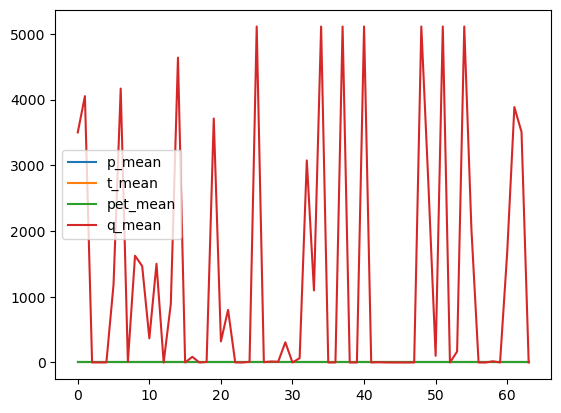

In [138]:
nan_counts_df.plot()

In [139]:
print(nan_counts_df[nan_counts_df.p_mean>0])
print(nan_counts_df[nan_counts_df.t_mean>0])
print(nan_counts_df[nan_counts_df.pet_mean>0])

Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []


In [140]:
# Save the dictionaries
path_inputs = r'..\data\models\inputgaronne\subset_2001_2015'

#np.save(path_inputs+'\\inputs.npy', inputs)
#np.save(path_inputs+'\\observations.npy', observations)
#np.save(path_inputs+'\\areas.npy', areas)
np.save(path_inputs+'\\perm_areas.npy', perm_areas)
#np.save(path_inputs+'\\quality_masks.npy', quality_masks)
#np.save(path_inputs+'\\rootdepth_mean.npy', rootdepth_mean)
#np.save(path_inputs+'\\waterdeficit_mean.npy', waterdeficit_mean)
#np.save(path_inputs+'\\perm_areasglobal.npy', perm_areasglobal)
#np.save(path_inputs+'\\perm_areascontinental.npy', perm_areascontinental)
#np.save(path_inputs+'\\prec_mean.npy', prec_mean)

In [141]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}
perm_areasglobal = {}
perm_areascontinental = {}
prec_mean = {}

# Function to compute S_dem per water year
def compute_S_dem(group):
    group = group.copy()
    group.iloc[0, group.columns.get_loc('S_dem(t-1)')] = 0
    group.iloc[0, group.columns.get_loc('S_dem(t)')] = max(
        0, group.iloc[0]['S_dem(t-1)'] + (group.iloc[0]['pet_mean'] - group.iloc[0]['p_mean'])
    )

    for i in range(1, len(group)):
        group.iloc[i, group.columns.get_loc('S_dem(t-1)')] = group.iloc[i - 1]['S_dem(t)']
        group.iloc[i, group.columns.get_loc('S_dem(t)')] = max(
            0, group.iloc[i]['S_dem(t-1)'] + (group.iloc[i]['pet_mean'] - group.iloc[i]['p_mean'])
        )

    return group

nan_counts_dict = {}

for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(path_estreams+"\data\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988-10-01":"2001-09-30", :]
    #data = data.loc["2001-10-01":"2015-09-30"]

    # Count NaN values in P and T
    nan_counts_dict[basin_id] = {
        "p_mean": data["p_mean"].isna().sum(),
        "t_mean": data["t_mean"].isna().sum(),
        "pet_mean": data["t_mean"].isna().isna().sum(),
        "q_mean": data["q_mean"].isna().sum()
        }
    

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()


    #data_wd = data.copy()
    #data_wd.index = pd.to_datetime(data_wd.index)

    # Define water year (Oct 1 to Sept 30)

    #data_wd['water_year'] = np.where(data_wd.index.month >= 10, data_wd.index.year + 1, data_wd.index.year)
    #data_wd['S_dem(t-1)'] = np.nan
    #data_wd['S_dem(t)'] = np.nan

    # Apply computation per water year
    #data_wd = data_wd.groupby('water_year', group_keys=False).apply(compute_S_dem)
    
    # Compute the 75% quantile of 'S_dem(t)' per water year
    #S_dem_75_per_year = data_wd.groupby('water_year')['S_dem(t)'].max()
    #S_dem_75_per_year = S_dem_75_per_year.quantile(0.75)

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    
    perm_areasglobal[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    
    perm_areascontinental[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_cont2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_cont2"] / 100, 2)]

    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    #waterdeficit_mean[basin_id] = np.float64(round(S_dem_75_per_year, 1))
    prec_mean[basin_id] = estreams_attributes.loc[basin_id, "p_mean"]

100%|██████████| 64/64 [00:02<00:00, 25.40it/s]


In [142]:
# Convert dictionary to DataFrame
nan_counts_df = pd.DataFrame.from_dict(nan_counts_dict, orient="index").reset_index()
nan_counts_df.rename(columns={"index": "basin_id"}, inplace=True)
nan_counts_df

,basin_id,p_mean,t_mean,pet_mean,q_mean
0,ES000333,0,0,0,3727
1,ES000453,0,0,0,3622
2,FR004086,0,0,0,131
3,FR004089,0,0,0,901
4,FR004091,0,0,0,0
...,...,...,...,...,...
59,FR001593,0,0,0,529
60,FR001595,0,0,0,2528
61,FR001596,0,0,0,4748
62,FR001602,0,0,0,0


In [143]:
print(nan_counts_df[nan_counts_df.p_mean>0])
print(nan_counts_df[nan_counts_df.t_mean>0])
print(nan_counts_df[nan_counts_df.pet_mean>0])

Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []
Empty DataFrame
Columns: [basin_id, p_mean, t_mean, pet_mean, q_mean]
Index: []


In [144]:
# Save the dictionaries
path_inputs = r'..\data\models\inputgaronne\subset_1988_2001'

#np.save(path_inputs+'\\inputs.npy', inputs)
#np.save(path_inputs+'\\observations.npy', observations)
#np.save(path_inputs+'\\areas.npy', areas)
np.save(path_inputs+'\\perm_areas.npy', perm_areas)
#np.save(path_inputs+'\\quality_masks.npy', quality_masks)
#np.save(path_inputs+'\\rootdepth_mean.npy', rootdepth_mean)
#np.save(path_inputs+'\\waterdeficit_mean.npy', waterdeficit_mean)
#np.save(path_inputs+'\\perm_areasglobal.npy', perm_areasglobal)
#np.save(path_inputs+'\\perm_areascontinental.npy', perm_areascontinental)
#np.save(path_inputs+'\\prec_mean.npy', prec_mean)

In [146]:
perm_areascontinental

{'ES000333': [0.0, 0.06, 0.94],
 'ES000453': [0.0, 0.02, 0.98],
 'FR004086': [0.0, 0.04, 0.96],
 'FR004089': [0.0, 0.03, 0.97],
 'FR004091': [0.0, 0.5, 0.5],
 'FR004093': [0.09, 0.28, 0.62],
 'FR004110': [0.0, 1.0, 0.0],
 'FR004114': [0.0, 0.56, 0.44],
 'FR004116': [0.08, 0.39, 0.53],
 'FR004119': [0.05, 0.95, 0.0],
 'FR004120': [0.31, 0.69, 0.0],
 'FR004125': [0.0, 0.43, 0.57],
 'FR004128': [0.0, 0.56, 0.44],
 'FR004130': [0.06, 0.55, 0.39],
 'FR004131': [0.0, 0.7, 0.3],
 'FR004132': [0.0, 0.77, 0.23],
 'FR004133': [0.0, 1.0, 0.0],
 'FR004136': [0.0, 0.53, 0.47],
 'FR004137': [0.0, 0.66, 0.34],
 'FR004138': [0.0, 1.0, 0.0],
 'FR004140': [0.08, 0.92, 0.0],
 'FR004141': [0.14, 0.8, 0.06],
 'FR004142': [0.19, 0.75, 0.06],
 'FR004143': [0.13, 0.63, 0.23],
 'FR004145': [0.13, 0.63, 0.24],
 'FR004147': [0.0, 0.98, 0.01],
 'FR004148': [0.0, 0.98, 0.01],
 'FR004149': [0.07, 0.93, 0.01],
 'FR004152': [0.18, 0.81, 0.0],
 'FR004153': [0.03, 0.97, 0.0],
 'FR004154': [0.38, 0.62, 0.0],
 'FR004156'

In [145]:
perm_areas

{'ES000333': [0.0, 0.06, 0.94],
 'ES000453': [0.0, 0.02, 0.98],
 'FR004086': [0.0, 0.04, 0.96],
 'FR004089': [0.0, 0.0, 1.0],
 'FR004091': [0.0, 0.49, 0.51],
 'FR004093': [0.04, 0.2, 0.76],
 'FR004110': [0.0, 0.82, 0.18],
 'FR004114': [0.0, 0.5, 0.5],
 'FR004116': [0.05, 0.3, 0.65],
 'FR004119': [0.01, 0.84, 0.15],
 'FR004120': [0.39, 0.53, 0.08],
 'FR004125': [0.0, 0.06, 0.94],
 'FR004128': [0.01, 0.13, 0.86],
 'FR004130': [0.06, 0.22, 0.72],
 'FR004131': [0.0, 0.77, 0.23],
 'FR004132': [0.0, 0.82, 0.18],
 'FR004133': [0.0, 1.0, 0.0],
 'FR004136': [0.0, 0.45, 0.55],
 'FR004137': [0.0, 0.6, 0.4],
 'FR004138': [0.0, 1.0, 0.0],
 'FR004140': [0.0, 1.0, 0.0],
 'FR004141': [0.11, 0.83, 0.06],
 'FR004142': [0.16, 0.78, 0.06],
 'FR004143': [0.12, 0.45, 0.43],
 'FR004145': [0.12, 0.44, 0.44],
 'FR004147': [0.0, 0.87, 0.13],
 'FR004148': [0.0, 0.88, 0.12],
 'FR004149': [0.0, 0.94, 0.06],
 'FR004152': [0.05, 0.91, 0.04],
 'FR004153': [0.21, 0.79, 0.0],
 'FR004154': [0.84, 0.16, 0.0],
 'FR004156'

# End